In [2]:
from transformers import LlavaForConditionalGeneration, AutoProcessor
import torch
from peft import peft_model, PeftModel

In [3]:
raw_model_name_or_path = "/blue/amolstad/y.jin/train-llava/my-model/model-01"
peft_model_name_or_path = "/blue/amolstad/y.jin/train-llava/Results"

model = LlavaForConditionalGeneration.from_pretrained(raw_model_name_or_path, 
                                                    device_map="cuda:0", 
                                                    torch_dtype=torch.float16)

model = PeftModel.from_pretrained(model, peft_model_name_or_path, adapter_name="peft_v1")
processor = AutoProcessor.from_pretrained(raw_model_name_or_path)
model.eval()
print('ok')



Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Qwen2Tokenizer'. 
The class this function is called from is 'CLIPTokenizerFast'.


ok


In [4]:
from utils.data import LlavaDataset

llavadataset = LlavaDataset("/blue/amolstad/y.jin/train-llava/data")
len(llavadataset), llavadataset[10]


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Qwen2Tokenizer'. 
The class this function is called from is 'CLIPTokenizerFast'.


(595375,
 ('<image>\nProvide a brief description of the given image.',
  'organization is synonymous with azaleas .',
  PosixPath('/blue/amolstad/y.jin/train-llava/data/images/GCC_train_000177248.jpg')))

In [15]:
testdata = llavadataset[102]
print(len(testdata))
print(testdata[0])
print(testdata[1])
print(testdata[2])

3
Give a short and clear explanation of the subsequent image.
<image>
chalkboard emblem written on a blackboard
/blue/amolstad/y.jin/train-llava/data/images/GCC_train_000463572.jpg


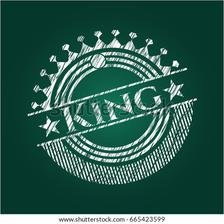

In [16]:
from PIL import Image
Image.open(testdata[2])

In [31]:
def build_model_input(model, processor, testdata):
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": testdata[0]},
    ]
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # print(prompt)
    # print("*" * 20)

    image = Image.open(testdata[2])
    inputs = processor(text=prompt, images=image, return_tensors="pt")

    for tk in inputs.keys():
        inputs[tk] = inputs[tk].to(model.device)

    generated_ids = model.generate(**inputs, max_new_tokens=20)

    generated_ids = [
        oid[len(iids):] for oid, iids in zip(generated_ids, inputs.input_ids)
    ]

    # gen_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]
    gen_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]

    return gen_text

In [32]:
build_model_input(model, processor, testdata)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


'c h a l k b o a r d   e m b l e m   w r i t t e n   o n   a   b l a c k b o a r d'

In [ ]:
model = model.merge_and_unload()

model.save_pretrained("output_model_lora_merge_001")
processor.save_pretrained("output_model_lora_merge_001")